In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy import spatial


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Generate random data

In [5]:
n_data = 42
xmin,xmax=(0,200)
x_range= xmax - xmin
ymin,ymax=(0,150)
y_range= ymax - ymin

np.random.seed(42)
coord_array = [xmin,ymin] \
                + np.array([x_range,y_range]).reshape(1,2)\
                 *np.random.random((n_data,2))
val_array = 2+ np.cos(coord_array[:,0]*np.pi/50) \
          + np.sin(coord_array[:,1]*np.pi/100)
data_array = np.concatenate((coord_array,val_array.reshape((-1,1))),axis=1)
data_col = ["X","Y","Z"]
data = pd.DataFrame(data=data_array, columns= data_col)
data.head()

,X,Y,Z
0,74.908024,142.607146,1.021071
1,146.398788,89.798773,1.340513
2,31.203728,23.399178,2.290671
3,11.616722,129.926422,1.937585
4,120.223002,106.210887,2.101776


In [6]:
class DataSet:
    def __init__(self,coord_array=None,val_array=None,box_array=None,coord_padding_perc=0.1):
        
        self.data = pd.DataFrame()
        self.coord_labels = None
        self.val_label = None
        self.update_val_range()
        self.coord_padding_perc = coord_padding_perc
        
        if coord_array is not None:
            self.set_coordinates(coord_array)
        if val_array is not None:
            self.set_values(val_array)
        self.set_bounding_box(box_array)
        
    def dimension(self):
        return len(self.coord_labels)
        
    def set_coordinates(self,coord_array):
        if not self.data.empty:
            self.data.drop(self.coord_labels,axis=1)
        self.coord_dim = np.array(coord_array).shape[1]
        self.coord_labels = ["X","Y","Z"][0:self.coord_dim]
        for col,label in enumerate(self.coord_labels):
            self.data[label] = coord_array[:,col]
        self.kd_tree = spatial.KDTree(self.coord())
    
    def set_random_coordinates(self,n_data,box_array,seed=None):
        if seed is not None:
            np.random.seed(seed)
            
        self.set_bounding_box(box_array)
        box_min = [self.box[coord_name+"_min"] for coord_name in self.coord_labels]
        box_range = [self.box[coord_name+"_range"] for coord_name in self.coord_labels]
        coord_array = box_min \
                + np.array(box_range).reshape(1,self.coord_dim)\
                 *np.random.random((n_data,self.coord_dim))
        self.set_coordinates(coord_array)
        
    def set_values(self,val_array,update_range=True):
        if self.coord_labels is None:
            print("Please load coordinates first")
            return
        self.val_label = "Z" if self.coord_dim<3 else "Val"
        if self.val_label in self.data.columns:
            self.data.drop(self.val_label)
        if "Val" in self.data.columns:
            self.data.drop("Val")
        val_array= np.array(val_array)
        self.val_dim = 1 if len(val_array.shape) is 1 else val_array.shape[1]
        self.data[self.val_label] = val_array
        
        if update_range:
            self.update_val_range()
        
    def compute_values(self,function,only_empty_values=False,update_range=True):
        if only_empty_values:
            self.data[self.val_label].fillna(
                self.data[self.data[self.val_label].null()].apply(function,axis=1,raw=True)
                ,inplace=True)
            if update_range:
                self.update_val_range()
        else:
            val_array = self.data.apply(function,axis=1,raw=True)
            self.set_values(val_array,update_range=update_range)
    
    def update_val_range(self):
        if self.val_label in self.data.columns:
            self.val_min = self.data[self.val_label].min()
            self.val_max = self.data[self.val_label].max()
        else:
            self.val_min = -1
            self.val_max = 1
    
    def set_bounding_box(self,box_array,coord_padding_perc=0):
        if box_array is None:
            self.box_needs_init_ = True
            self.box = None
        else:
            if self.coord_labels is None:
                self.coord_dim =len(box_array)
                self.coord_labels = ["X","Y","Z"][0:self.coord_dim]
            else:
                assert (len(self.coord_labels)==len(box_array)), "Bounding box dim must match coord array dim"
            self.box_needs_init_ = False
            self.box = {}
            for coord_name,min_,max_ in [(self.coord_labels[i],*box_array[i]) for i in range(self.coord_dim)]:
                range_ = max_ - min_
                self.box[coord_name+"_min"] = min_
                self.box[coord_name+"_max"] = max_
                self.box[coord_name+"_range"] = self.box[coord_name+"_max"] - self.box[coord_name+"_min"]
    
    def update_bounding_box(self):
        """Recompute the bounding box range based on the dataset."""
        assert(self.data is not None), "Data must be initialised first"
        self.box = {}
        for i,coord_name in enumerate(self.coord_labels):
            min_ = data[coord_name].min() 
            max_ = data[coord_name].max()
            range_ = max_ - min_
            self.box[coord_name+"_min"] = min_ - self.coord_padding_perc * range_
            self.box[coord_name+"_max"] = max_ + self.coord_padding_perc * range_
            self.box[coord_name+"_range"] = self.box[coord_name+"_max"] - self.box[coord_name+"_min"]
        self.box_needs_init_ = False
        
    def max_dist(self):
        return np.sqrt(np.sum(np.square([self.box[coord+"_range"] for coord in self.coord_labels])))
    
    def smallest_box_width(self):
        return min([self.box[coord_name+"_range"] for coord_name in self.coord_labels])
    
    def coord(self):
        return self.data[self.coord_labels]
    def val(self):
        return self.data[self.val_label]
        
    def show(self,ax=None,coord_padding_perc=None,highlight_index=None):
        if coord_padding_perc is not None:
            self.coord_padding_perc
            self.update_bounding_box()
        if self.box_needs_init_:
            self.update_bounding_box()
        
        axis = plt.gca() if ax is None else ax
        
        data_axis = None
        if self.coord_dim == 1:
            values = 0 if self.val_label is None else self.data[self.val_label]
            data_axis = axis.scatter(self.data[self.coord_labels[0]],values)
            if highlight_index is not None:
                axis.scatter(self.data.loc[highlight_index,self.coord_labels[0]],values[highlight_index],
                             edgecolor="orange",linewidth=1.8,facecolor="none",zorder=10)
            x_padding = self.coord_padding_perc * self.box["X_range"]
            axis.set_xlim(self.box["X_min"]-x_padding,self.box["X_max"]+x_padding)
            axis.set_ylim(self.val_min,self.val_max)
        else:
            values = None if self.val_label is None else self.data[self.val_label]
            data_axis = axis.scatter(self.data["X"],self.data["Y"],c=values,
                    cmap="viridis",
                    vmin= self.val_min,
                    vmax= self.val_max,
                    edgecolor="k",
                    zorder=1)
            
            if highlight_index is not None:
                axis.scatter(self.data.loc[highlight_index,"X"],self.data.loc[highlight_index,"Y"],
                             edgecolor="orange",s=(1.25*mpl.rcParams['lines.markersize'])**2,linewidth=2,facecolor="none",zorder=10)
            axis.axis('equal')
            x_padding = self.coord_padding_perc * self.box["X_range"]
            axis.set_xlim(self.box["X_min"]-x_padding,self.box["X_max"]+x_padding)
            y_padding = self.coord_padding_perc * self.box["Y_range"]
            axis.set_ylim(self.box["Y_min"]-y_padding,self.box["Y_max"]+y_padding)
            if self.val_label is not None : plt.gcf().colorbar(data_axis)
        
    def distance_matrix(self):
        return spatial.distance_matrix(self.coord(),self.coord())
    
    def closest_dist(self):
        distance_matrix = self.distance_matrix()
        positive_distance_matrix = distance_matrix[np.where(distance_matrix>0)].reshape((len(self.data),len(self.data)-1))
        return np.amin(positive_distance_matrix,axis=0)
                         
    def pairs(self,max_dist=None,min_dist=None, as_array=True):
        if (min_dist is None) and (max_dist is None):
            pair_array = np.array([[[i,j] for i in range(len(self.data))]for j in range(len(self.data))]).reshape((-1,2))
            return pair_array if as_array else set(pair_array)
        else:
            pairs_below_min_dist = self.kd_tree.query_pairs(min_dist) if min_dist is not None else set()
            pairs_below_max_dist = self.kd_tree.query_pairs(max_dist)
            pair_diff = pairs_below_max_dist - pairs_below_min_dist
            return pair_diff if as_array is False else np.array([[i,j] for i,j in pair_diff])
    
    
    def pair_positions(self,pair_indexes):
        return self.data.loc[pair_indexes.ravel() if isinstance(pair_indexes,np.ndarray) else pair_indexes,
                             ["X","Y"]].values.reshape((-1,2,2))
    
    def pair_dist(self,pair_indexes):
        positions = self.pair_positions(pair_indexes)
        return positions
    
    def show_pairs(self,max_dist=None,min_dist=None,pairs=None,ax=None,marker_edgecolors=None,highlight_index=None):
        axis = plt.gca() if ax is None else ax
        
        pairs = self.pairs(min_dist=min_dist,max_dist= self.max_dist() if max_dist is None else max_dist)\
                    if pairs is None else pairs
        if self.coord_dim == 1:
            values = 0 if self.val_label is None else self.data[self.val_label]
            axis.scatter(self.data.loc[pairs[:,0],["X"]],values[pairs[:,0]],facecolor="none",edgecolors=marker_edgecolors,zorder=2)
            axis.scatter(self.data.loc[pairs[:,1],["X"]],values[pairs[:,1]],facecolor="none",edgecolors=marker_edgecolors,zorder=2)
            
            segs = self.data.loc[pairs.ravel(),["X",self.val_label]].values.reshape((-1,2,2))
            line_collection = LineCollection(segs,colors="red",zorder=0)
            axis.add_collection(line_collection)
            
            if highlight_index is not None:
                axis.scatter(self.data.loc[pairs[highlight_index,0],["X"]],values[pairs[highlight_index,0]],
                             facecolor="none",edgecolors="cyan",linewidth=1.8,zorder=5)
                axis.scatter(self.data.loc[pairs[highlight_index,1],["X"]],values[pairs[highlight_index,1]],
                             facecolor="none",edgecolors="cyan",linewidth=1.8,zorder=5)
                axis.plot(self.data.loc[pairs[highlight_index],"X"],
                          values[pairs[highlight_index]], "-",color="cyan",zorder=5)
            x_padding = self.coord_padding_perc * self.box["X_range"]
            axis.set_xlim(self.box["X_min"]-x_padding,self.box["X_max"]+x_padding)
            axis.set_ylim(self.val_min,self.val_max)
        else:
            axis.scatter(self.data.loc[pairs[:,0],["X"]],self.data.loc[pairs[:,0],["Y"]],facecolor="none",edgecolors="red",zorder=2)
            axis.scatter(self.data.loc[pairs[:,1],["X"]],self.data.loc[pairs[:,1],["Y"]],facecolor="none",edgecolors="red",zorder=2)
            
            segs = self.pair_positions(pairs)
            line_collection = LineCollection(segs,colors="red",zorder=0)
            axis.add_collection(line_collection)
            
            if highlight_index is not None:
                axis.scatter(self.data.loc[pairs[highlight_index,0],["X"]],self.data.loc[pairs[highlight_index,0],["Y"]],
                             facecolor="none",edgecolors="dodgerblue",s=(1.25*mpl.rcParams['lines.markersize'])**2,linewidth=2,zorder=5)
                axis.scatter(self.data.loc[pairs[highlight_index,1],["X"]],self.data.loc[pairs[highlight_index,1],["Y"]],
                             facecolor="none",edgecolors="dodgerblue",s=(1.25*mpl.rcParams['lines.markersize'])**2,linewidth=2,zorder=5)
                axis.plot(self.data.loc[pairs[highlight_index],"X"],
                          self.data.loc[pairs[highlight_index],"Y"], "-",color="dodgerblue",zorder=0)
            axis.axis('equal')
            x_padding = self.coord_padding_perc * self.box["X_range"]
            axis.set_xlim(self.box["X_min"]-x_padding,self.box["X_max"]+x_padding)
            y_padding = self.coord_padding_perc * self.box["Y_range"]
            axis.set_ylim(self.box["Y_min"]-y_padding,self.box["Y_max"]+y_padding)

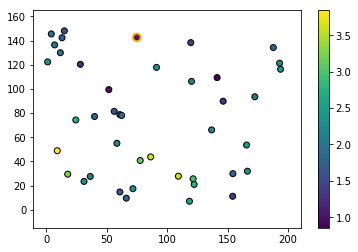

In [7]:
dataset = DataSet()
dataset.set_random_coordinates(n_data=42,box_array=[[0,200],[0,150]],seed=42)
dataset.compute_values(function= lambda coord: 2+ np.cos(coord[0]*np.pi/50) + np.sin(coord[1]*np.pi/100))
dataset.show(highlight_index=0)

In [8]:
dataset.dimension()

2

In [9]:
dataset.data.describe()

,X,Y,Z
count,42.000000,42.000000,42.000000
mean,85.278758,75.869749,2.136137
std,59.634662,46.661198,0.695931
min,1.104423,6.967562,0.853832
25%,32.494044,29.499910,1.726905
50%,73.300585,77.572684,2.077893
75%,133.227599,119.691259,2.417125
max,193.916926,148.033040,3.842083


# Spatial manipulations

In [10]:
dataset.distance_matrix()

array([[  0.        ,  88.87999615, 126.96694481, ..., 125.26804713,
        109.36084619, 133.35933912],
       [ 88.87999615,   0.        , 132.96167896, ..., 104.04498877,
         26.48108556, 113.47947318],
       [126.96694481, 132.96167896,   0.        , ...,  40.93432695,
        157.83580271,  37.62395498],
       ...,
       [125.26804713, 104.04498877,  40.93432695, ...,   0.        ,
        126.41109143,   9.59001373],
       [109.36084619,  26.48108556, 157.83580271, ..., 126.41109143,
          0.        , 135.56971434],
       [133.35933912, 113.47947318,  37.62395498, ...,   9.59001373,
        135.56971434,   0.        ]])

In [11]:
np.median(dataset.closest_dist())

9.590013725114137

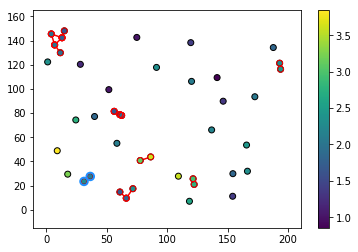

In [12]:
dataset.show()
dataset.show_pairs(min_dist=0,max_dist=10,highlight_index=0)

# Variogram

In [13]:
class Variogram:
    
    def __init__(self,dataset):
        self.dataset = dataset
        self.dim = self.dataset.dimension()
        self.max_dist = self.dataset.max_dist()
        self.classes = None
        self.vario = None
        self.vario_cloud = None
        self.set_direction()
    
    def set_direction(self,azimuth=None, dip=0,roll=0):
        if azimuth is None:
            self.type = "isotropic"
            self.azimuth = None
            self.dip = None
            self.roll = None
            self.dir_vectors = None
            self.dir_rotation = spatial.transform.Rotation()
        elif self.dim<2:
            print("Warning: 1D variogram can't be anisotropic.\n Making it isotropic instead.")
            self.set_direction()
        else:
            self.dir_vectors = np.identity(self.dataset.dimension())
            self.azimuth = azimuth
            rotation_angle = [azimuth,dip,roll]
            if self.dim>2:
                self.dip = dip
                self.roll = roll
                rotation_dir= "z"
            self.dir_rotation = spatial.transform.Rotation.from_euler("zyx",np.diag(rotation_angle))
        
    def select_pairs(self,min_dist=0,max_dist=None):
        self.pairs = self.dataset.pairs(min_dist=min_dist,max_dist= self.max_dist if max_dist is None else max_dist)
    
    def compute_step(self):
        self.poz = self.dataset.pair_positions(self.pairs)
        self.vec = self.poz[:,1] - self.poz[:,0]
        self.h_cloud = np.linalg.norm(self.vec,axis=1)
    
    def compute_vario_cloud(self,min_dist=0,max_dist=None):
        self.select_pairs(min_dist,max_dist)
        self.compute_step()
        
        self.val0 = self.dataset.data.loc[self.pairs[:,0],self.dataset.val_label].values
        self.val1 = self.dataset.data.loc[self.pairs[:,1],self.dataset.val_label].values
        self.delta = self.val1 - self.val0
        self.vario_cloud = self.delta**2
    
    def setup_lags(self,lag_unit_distance=None,nb_lags=None,max_lag_distance=None):
        if (lag_unit_distance is None) and (nb_lags is None) and (max_lag_distance is None):
            self.lag_unit_distance = self.guess_lag_unit_distance()
            self.nb_lags = self.guess_nb_lags()
            self.max_lag_distance = self.lag_unit_distance * self.nb_lags
        elif lag_unit_distance is not None:
            self.lag_unit_distance = lag_unit_distance
            if (nb_lags is None) and (max_lag_distance is None):
                self.nb_lags = self.guess_nb_lags()
                self.max_lag_distance = self.lag_unit_distance * self.nb_lags
            elif max_lag_distance is None:
                self.nb_lags = nb_lags
                self.max_lag_distance = self.lag_unit_distance * self.nb_lags
            else:
                self.max_lag_distance = max_lag_distance
                self.nb_lags = int(np.ceil(self.max_lag_distance / self.lag_unit_distance))
        elif max_lag_distance is not None:
            self.max_lag_distance = max_lag_distance
            if lag_unit_distance is None:
                if nb_lags is None:
                    self.lag_unit_distance = self.guess_lag_unit_distance() if lag_unit_distance is None else lag_unit_distance
                    self.nb_lags = int(np.ceil(self.max_lag_distance / self.lag_unit_distance))            
                else:
                    self.nb_lags= nb_lags
                    self.lag_unit_distance = self.max_lag_distance / self.nb_lags
            else:
                self.lag_unit_distance = lag_unit_distance
                self.nb_lags = int(np.ceil(self.max_lag_distance / self.lag_unit_distance))
                            
        classes = np.linspace(0,self.max_lag_distance,int(self.nb_lags)+1,endpoint=True)
        self.setup_distance_classes(classes)
        
    def guess_lag_unit_distance(self,method="median"):
        closest_dist = self.dataset.closest_dist()
        if method is "min":
            return min(closest_dist)
        elif method is "mean":
            return np.mean(closest_dist)
        elif method is "median":
            return np.median(closest_dist)
    
    def guess_nb_lags(self):
        return self.dataset.smallest_box_width()/2/self.lag_unit_distance
        
    def setup_distance_classes(self,classes):
        self.classes = np.sort(classes)
        self.compute_vario_cloud(max_dist=self.classes[-1])
        
        self.h_slices = np.ravel([
            np.all(np.concatenate(([self.h_cloud >h_min],[self.h_cloud<h_max]),axis=0),axis=0)
              for h_min,h_max in zip(self.classes[0:-1],self.classes[1:])
        ]).reshape((-1,len(self.h_cloud)))
        
    def compute_variogram(self,method_h=np.mean,method_vario=np.mean):
        if self.classes is None:
            self.setup_lags()
        self.vario_h = [method_h(self.h_cloud[slice_i]) for slice_i in self.h_slices if slice_i.size >0]
        self.vario = [method_vario(self.vario_cloud[slice_i]) for slice_i in self.h_slices if slice_i.size >0]  
        
    def get_pairs_class(self,class_index):
        return self.pairs[self.h_slices[class_index]]
    
    def show(self,show_vario=True,show_cloud=False,show_classes=False,ax=None,ymax=None,
            selected_lag=None,selected_pair=None):
        axis = plt.gca() if ax is None else ax
        
        if show_cloud and self.vario_cloud is not None:
            axis.scatter(self.h_cloud,self.vario_cloud,
                         facecolor="darkgray",edgecolors="none",s=(0.25*mpl.rcParams['lines.markersize'])**2)
            if (selected_lag is not None) and (selected_pair is not None):
                axis.scatter(self.h_cloud[self.h_slices[selected_lag]][selected_pair],
                             self.vario_cloud[self.h_slices[selected_lag]][selected_pair],
                         facecolor="dodgerblue",edgecolors="none",s=(1*mpl.rcParams['lines.markersize'])**2,zorder=10)
                
        
        if show_vario and self.vario is not None:
            axis.plot(self.vario_h,self.vario,"bo--")
            if selected_lag is not None:
                axis.scatter(self.vario_h[selected_lag],self.vario[selected_lag],c="red",zorder=6)
        
        if ymax is None:
            if self.vario is None:
                if self.vario_cloud is None:
                    ymax = 10
                else:
                    ymax = max(self.vario_cloud)
            else:
                ymax= 1.05*max(self.vario)
        axis.set_ylim(0,ymax)
        
        if show_classes and self.classes is not None:
            bin_segs = [[[x_i,0],[x_i,0.95*ymax]] for x_i in self.classes]
            line_collection = LineCollection(bin_segs,
                                colors="gray",linestyle=(0,(5,8)),linewidth=0.5,
                                zorder=5)
            axis.add_collection(line_collection)
            
            if selected_lag is not None:
                bin_segs = [[[x_i,0],[x_i,0.95*ymax]] for x_i in self.classes[[selected_lag,selected_lag+1]]]
                line_collection = LineCollection(bin_segs,
                                    colors="red",linestyle=(0,(5,8)),linewidth=0.5,
                                    zorder=5)
                axis.add_collection(line_collection)
                
    def show_variogram_range(self,ax=None):
        axis = plt.gca() if ax is None else ax
        
        if self.dim == 1:
            print("to be implemented")
        else:
            vectors = np.identity()
            transformed_vectors = self.dir_rotation.apply()
            if self.dim == 2:
                print("to be implemented")
            else:
                print("to be implemented")

In [14]:
rot = spatial.transform.Rotation.from_euler("zyx",np.diag([20,0,0]))

AttributeError: module 'scipy.spatial' has no attribute 'transform'

In [15]:
import scipy
scipy.__version__

'1.1.0'

In [ ]:
scipy

In [16]:
vario = Variogram(dataset)
vario.compute_vario_cloud()
vario.setup_lags(max_lag_distance=200,lag_unit_distance=20)
vario.compute_variogram()
vario.show(show_cloud = True,show_classes=True)

AttributeError: module 'scipy.spatial' has no attribute 'transform'

NameError: name 'vario' is not defined

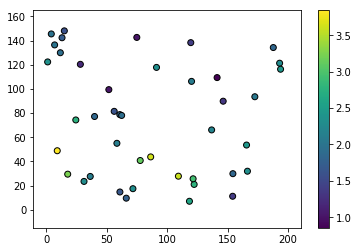

In [17]:
dataset.show()
dataset.show_pairs(pairs=vario.get_pairs_class(0))

In [18]:
vario.show(show_cloud = True,show_classes=True)
vario.compute_variogram(method_h=np.median)
vario.show(show_cloud = False,show_classes=False)

NameError: name 'vario' is not defined

In [19]:
vario = Variogram(dataset)
vario.compute_vario_cloud()
vario.setup_lags()
vario.compute_variogram()
lag_unit_distance_widget = widgets.FloatSlider(min=0.01,max=vario.dataset.max_dist(),step=1, value=vario.lag_unit_distance, continuous_update=True)
max_lag_distance_widget = widgets.FloatSlider(min=vario.dataset.max_dist()/1000,max=vario.dataset.max_dist(),step=1, value=vario.max_lag_distance, continuous_update=True)
selected_lag_widget = widgets.IntSlider(min=0,max = vario.nb_lags, step =1, value=0, continuous_update=True )
selected_pair_widget = widgets.IntSlider(min=0,max = 1, step =1, value=0, continuous_update=True )

def update_max_lag(*args):
    vario.setup_lags(max_lag_distance=max_lag_distance_widget.value,lag_unit_distance=lag_unit_distance_widget.value)
    selected_lag_widget.max = vario.nb_lags
    
max_lag_distance_widget.observe(update_max_lag,"value")
lag_unit_distance_widget.observe(update_max_lag,"value")

def update_selected_pair_max(*args):
    vario.setup_lags(max_lag_distance=max_lag_distance_widget.value,lag_unit_distance=lag_unit_distance_widget.value)
    selected_pair_widget.max = len(vario.pairs[vario.h_slices[selected_lag_widget.value]])-1
    selected_pair_widget.value=0
    
max_lag_distance_widget.observe(update_selected_pair_max,"value")
lag_unit_distance_widget.observe(update_selected_pair_max,"value")
selected_lag_widget.observe(update_selected_pair_max,"value")

@interact(
    lag_unit_distance=lag_unit_distance_widget,
    max_lag_distance=max_lag_distance_widget,
    selected_lag=selected_lag_widget,
    selected_pair=selected_pair_widget,
    vario=fixed(vario))
def explore_vario(lag_unit_distance,max_lag_distance,selected_lag,selected_pair,vario):
    fig,axes = plt.subplots(1,2)
    
    vario.setup_lags(max_lag_distance=max_lag_distance,lag_unit_distance=lag_unit_distance)
    vario.compute_variogram()
    vario.show(show_cloud = True,show_classes=True,ax=axes[0],selected_lag=selected_lag,selected_pair=selected_pair)
    
    dataset.show(ax=axes[1])
    dataset.show_pairs(pairs=vario.get_pairs_class(selected_lag),ax=axes[1],highlight_index=selected_pair)
    fig.set_size_inches((16,6))

AttributeError: module 'scipy.spatial' has no attribute 'transform'

# 2D cours

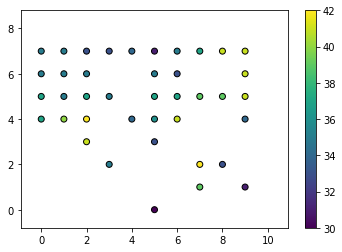

In [41]:
dataset = DataSet(
    coord_array=[0,8]+[1,-1]*(np.array([[1,j] for j in range(10)]+\
[[2,j] for j in range(3)]+[[2,5+j] for j in range(2)]+[[2,9]]+\
[[3,j] for j in range(4)]+[[3,5+j] for j in range(5)]+\
[[4,j] for j in range(3)]+[[4,4+j] for j in range(3)]+[[4,9]]+\
[[5,2],[5,5],[6,3],[6,7],[6,8],[7,7],[7,9],[8,5]])[:,[1,0]]),
    val_array=[35,35,33,33,34,31,35,37,41,41,35,35,35,35,33,41,37,35,37,35,37,37,39,39,41,37,40,42,34,36,41,34,41,33,35,42,33,39,31,30],
    box_array=[[0,10],[0,8]]
)
dataset.show()

In [42]:
dataset.data

,X,Y,Z
0,0,7,35
1,1,7,35
2,2,7,33
3,3,7,33
4,4,7,34
5,5,7,31
6,6,7,35
7,7,7,37
8,8,7,41
9,9,7,41


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Axis limits cannot be NaN or Inf

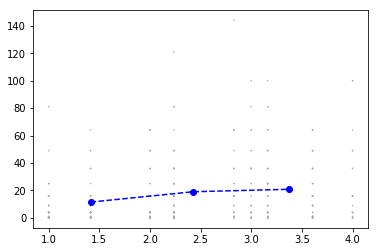

In [259]:
vario = Variogram(dataset)
vario.compute_vario_cloud()
vario.setup_lags()#max_lag_distance=7,lag_unit_distance=1.5)
vario.compute_variogram()
vario.show(show_cloud = True,show_classes=True,show_vario=True)

In [261]:
vario.vario

[nan, 11.527777777777779, 19.066666666666666, 20.86813186813187]

In [256]:
dataset.data.describe()

,X,Y,Z
count,40.000000,40.000000,40.000000
mean,4.550000,4.825000,36.350000
std,2.960856,1.920036,3.278133
min,0.000000,0.000000,30.000000
25%,2.000000,4.000000,34.000000
50%,5.000000,5.000000,35.000000
75%,7.000000,6.250000,39.000000
max,9.000000,7.000000,42.000000


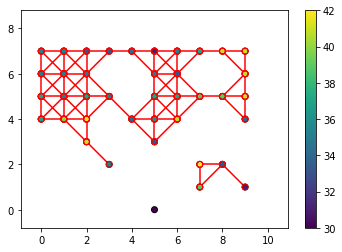

In [240]:
dataset.show()
dataset.show_pairs(pairs=vario.get_pairs_class(0))

In [257]:
vario = Variogram(dataset)
vario.compute_vario_cloud()
vario.setup_lags(max_lag_distance=12,lag_unit_distance=1.5)
vario.compute_variogram()
lag_unit_distance_widget = widgets.FloatSlider(min=0.01,max=vario.dataset.max_dist(),step=1, value=vario.lag_unit_distance, continuous_update=True)
max_lag_distance_widget = widgets.FloatSlider(min=vario.dataset.max_dist()/1000,max=vario.dataset.max_dist(),step=1, value=vario.max_lag_distance, continuous_update=True)
selected_lag_widget = widgets.IntSlider(min=0,max = vario.nb_lags-1, step =1, value=0, continuous_update=True )
selected_pair_widget = widgets.IntSlider(min=0,max = 1, step =1, value=0, continuous_update=False )

def update_max_lag(*args):
    vario.setup_lags(max_lag_distance=max_lag_distance_widget.value,lag_unit_distance=lag_unit_distance_widget.value)
    selected_lag_widget.max = vario.nb_lags
    
max_lag_distance_widget.observe(update_max_lag,"value")
lag_unit_distance_widget.observe(update_max_lag,"value")

def update_selected_pair_max(*args):
    vario.setup_lags(max_lag_distance=max_lag_distance_widget.value,lag_unit_distance=lag_unit_distance_widget.value)
    selected_pair_widget.max = len(vario.pairs[vario.h_slices[selected_lag_widget.value]])-1
    selected_pair_widget.value=0
    
max_lag_distance_widget.observe(update_selected_pair_max,"value")
lag_unit_distance_widget.observe(update_selected_pair_max,"value")
selected_lag_widget.observe(update_selected_pair_max,"value")

@interact(
    lag_unit_distance=lag_unit_distance_widget,
    max_lag_distance=max_lag_distance_widget,
    selected_lag=selected_lag_widget,
    selected_pair=selected_pair_widget,
    vario=fixed(vario))
def explore_vario(lag_unit_distance,max_lag_distance,selected_lag,selected_pair,vario):
    fig,axes = plt.subplots(1,2)
    
    vario.setup_lags(max_lag_distance=max_lag_distance,lag_unit_distance=lag_unit_distance)
    vario.compute_variogram()
    vario.show(show_cloud = True,show_classes=True,ax=axes[0],selected_lag=selected_lag,selected_pair=selected_pair)
    
    dataset.show(ax=axes[1])
    dataset.show_pairs(pairs=vario.get_pairs_class(selected_lag),ax=axes[1],highlight_index=selected_pair)
    fig.set_size_inches((16,6))

interactive(children=(FloatSlider(value=1.5, description='lag_unit_distance', max=12.806248474865697, min=0.01…

# 1D Dataset

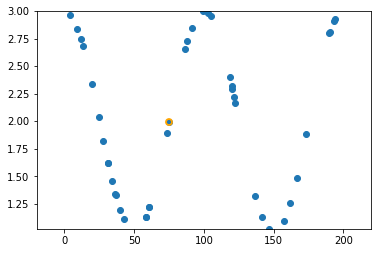

In [201]:
data_1d = DataSet()
data_1d.set_random_coordinates(n_data=42,box_array=[[0,200]],seed=42)
data_1d.compute_values(function= lambda coord: 2+ np.cos(coord[0]*np.pi/50))
data_1d.show(highlight_index=0)

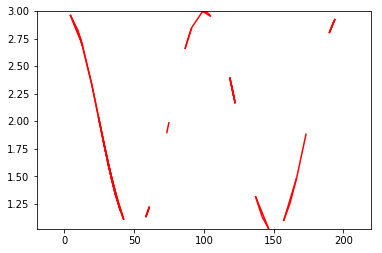

In [203]:
data_1d.show_pairs(max_dist=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:171: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


interactive(children=(FloatSlider(value=1.641495019497114, description='lag_unit_distance', max=200.0, min=0.0…

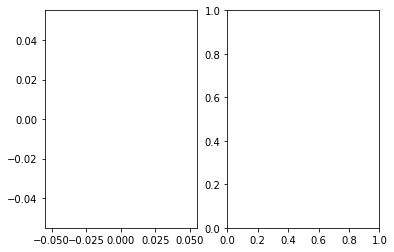

In [200]:
vario = Variogram(data_1d)
vario.compute_vario_cloud()
vario.setup_lags()
vario.compute_variogram()
lag_unit_distance_widget = widgets.FloatSlider(min=0.01,max=vario.dataset.max_dist(),step=1, value=vario.lag_unit_distance, continuous_update=True)
max_lag_distance_widget = widgets.FloatSlider(min=vario.dataset.max_dist()/1000,max=vario.dataset.max_dist(),step=1, value=vario.max_lag_distance, continuous_update=True)
selected_lag_widget = widgets.IntSlider(min=0,max = vario.nb_lags, step =1, value=0, continuous_update=True )
selected_pair_widget = widgets.IntSlider(min=0,max = 1, step =1, value=0, continuous_update=True )

def update_max_lag(*args):
    vario.setup_lags(max_lag_distance=max_lag_distance_widget.value,lag_unit_distance=lag_unit_distance_widget.value)
    selected_lag_widget.max = vario.nb_lags
    
max_lag_distance_widget.observe(update_max_lag,"value")
lag_unit_distance_widget.observe(update_max_lag,"value")

def update_selected_pair_max(*args):
    vario.setup_lags(max_lag_distance=max_lag_distance_widget.value,lag_unit_distance=lag_unit_distance_widget.value)
    selected_pair_widget.max = len(vario.pairs[vario.h_slices[selected_lag_widget.value]])-1
    selected_pair_widget.value=0
    
max_lag_distance_widget.observe(update_selected_pair_max,"value")
lag_unit_distance_widget.observe(update_selected_pair_max,"value")
selected_lag_widget.observe(update_selected_pair_max,"value")

@interact(
    lag_unit_distance=lag_unit_distance_widget,
    max_lag_distance=max_lag_distance_widget,
    selected_lag=selected_lag_widget,
    selected_pair=selected_pair_widget,
    vario=fixed(vario))
def explore_vario(lag_unit_distance,max_lag_distance,selected_lag,selected_pair,vario):
    fig,axes = plt.subplots(1,2)
    
    vario.setup_lags(max_lag_distance=max_lag_distance,lag_unit_distance=lag_unit_distance)
    vario.compute_variogram()
    vario.show(show_cloud = True,show_classes=True,ax=axes[0],selected_lag=selected_lag,selected_pair=selected_pair)
    
    dataset.show(ax=axes[1])
    dataset.show_pairs(pairs=vario.get_pairs_class(selected_lag),ax=axes[1],highlight_index=selected_pair)
    fig.set_size_inches((16,6))